## Integrantes

- **Estudiante 1:** Juan David Duarte Yara - 202215070
- **Estudiante 2:** Luisa Gabriela Hernández Pérez - 202114093
- **Estudiante 3:** Juan Sebastian Sanchez - 202121498
- Todos los estudiantes aportaron en las partes generales del notebook y en las diapositivas de coclusiones.



## 0. Carga de los datos. 

### 0.1. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [1]:
# Importaciones de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
import re
import string
import unicodedata

# Importaciones de joblib
from joblib import dump, load

# Importaciones de sklearn
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Clasificacion
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

# Importaciones de statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Importaciones de nltk
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer, SnowballStemmer

# Instalación de paquetes adicionales
import contractions

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Para la validación cruzada
from sklearn.model_selection import KFold

### 0.2. Lectura de archivos
A través de la librería **pandas** podemos realizar la carga de datos desde diferentes fuentes de información, en este caso se realizará la carga de un archivo plano csv (archivo separado por comas).

In [2]:
# Se cargan los datos. 
datatrain=pd.read_csv('fake_news_spanish.csv', sep=';', encoding = 'utf-8')#, nrows=500)
datatest = pd.read_csv('fake_news_test.csv', sep=';', encoding = 'utf-8')

Podemos ver que hay 57,063 filas y 5 columnas de atributos en el conjunto de entrenamiento

In [3]:
datatrain.shape

(57063, 5)

Podemos ver que hay 1000 filas y 4 columnas de atributos en el conjunto de prueba

In [4]:
datatest.shape

(1000, 4)

Veamos un pequeño sample de los datos

In [5]:
datatrain.sample(10)

,ID,Label,Titulo,Descripcion,Fecha
26035,ID,1,Los regionalistas enfrían la investidura de Sá...,Tanto el BNG como el PRC advierten de que no h...,18/12/2019
55784,ID,1,El BNG propone movilizar 1.000 millones en Gal...,"Frente a la pasividad del sucesor de Feijóo, p...",29/08/2022
25435,ID,0,El BNG evidencia su falta de proyecto para Cat...,En el BNG confiesan que nadie sabe muy bien qu...,22/06/2021
15111,ID,1,JxCat plantea abandonar la mesa de diálogo en ...,Así lo detalla en el borrador de la ponencia p...,07/06/2022
17359,ID,1,El Govern aprueba el decreto para poder impone...,Quim Torra ha reunido esta tarde a su Govern p...,13/07/2020
8174,ID,0,Cada vez que se realiza una denuncia falsa por...,Cada vez que en España se tramita una denuncia...,16/11/2019
42748,ID,1,La Fiscalía pide seis años de prisión para el ...,"Daniel Gallardo Herzog, de 22 años, lleva más ...",29/05/2020
54761,ID,0,El BNG reprueba a la concejala que deseó la mu...,"Susana Pancho, edil de Moguer, difundió un víd...",10/09/2021
31429,ID,1,Belarra celebra la aprobación de la ley de viv...,El Consejo de Ministros aprueba la nueva norma...,01/02/2022
16920,ID,1,ERC abre juego para la investidura con apelaci...,"El presidenciable republicano, Pere Aragonès, ...",15/02/2021


Revisemos que el tipo de dato sea el esperado

In [6]:
datatrain.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

In [7]:
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


---


# 2. Entendimiento de los datos

## 2.1 Analisis descriptivo

Podemos ver que hay textos repetidos

In [8]:
datatrain["Descripcion"].describe()


count                                                 57063
unique                                                49638
top       La Fundación En Acción ha participado con Públ...
freq                                                      7
Name: Descripcion, dtype: object

Es útil saber que tan largos son los textos

In [9]:
datatrain["Descripcion"].apply(len).describe()

count    57063.000000
mean       243.519724
std        274.479568
min         33.000000
25%        171.000000
50%        221.000000
75%        267.000000
max      14153.000000
Name: Descripcion, dtype: float64

Los textos tienen una longitud entre 33 y 14,153 caracteres, con una media de 243 caracteres. 

Queremos ver ahora la columna "label"

In [10]:
datatrain["Label"].describe()

count    57063.000000
mean         0.581077
std          0.493387
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

Podemos ver que efectivamente la columna "Label" tiene valores entre 0 y 1.

Nos gustaría saber la proporción que hay entre noticias falsas y las que no

In [11]:
datatrain["Label"].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

Podemos ver que los datos están ligeramente desbalanceados

In [12]:
datatrain.head(2)


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023


In [13]:
datatrain[["Titulo", "Descripcion"]].head(2)

,Titulo,Descripcion
0,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...
1,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...


Estadisticas de cada registro del tamaño del texto concatenado entre 
- *Conteo total:* titulo + descripcion
- *Conteo titulo:* titulo 
- *Conteo descripcion:*  descripcion
- *Min* : palabra mas corta de cada registro
- *Max* : palabra mas larga de cada registro


In [14]:
textos = datatrain.copy()
textos["Message"] = (textos["Titulo"] + " " + textos["Descripcion"]).astype(str)

textos["Conteo total"] = textos["Message"].str.len()
textos["Conteo titulo"] = textos["Titulo"].str.len()
textos["Conteo descripcion"] = textos["Descripcion"].str.len()

textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

textos[["Conteo total", "Conteo titulo", "Conteo descripcion", "Max", "Min"]].describe()

,Conteo total,Conteo titulo,Conteo descripcion,Max,Min
count,57063.000000,57047.000000,57063.000000,57063.000000,57063.000000
mean,338.816221,94.796133,243.519724,13.098610,1.067504
std,272.214467,21.827680,274.479568,2.061113,0.269160
min,3.000000,12.000000,33.000000,3.000000,0.000000
25%,264.000000,80.000000,171.000000,12.000000,1.000000
50%,316.000000,95.000000,221.000000,13.000000,1.000000
75%,369.000000,111.000000,267.000000,14.000000,1.000000
max,14237.000000,258.000000,14153.000000,69.000000,3.000000


## 2.2 Calidad de datos

In [15]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
data_t = datatrain.copy()

### Unicidad

Revisemos los duplicados por título 

In [16]:
data_t.loc[datatrain.duplicated(subset= "Titulo", keep = False)].sort_values("Titulo").head(10)

,ID,Label,Titulo,Descripcion,Fecha
53500,ID,1,"""La quimioterapia mata a la gente y no al cánc...",Señor Presidente recibiremos sus tropas con lo...,01/11/2018
27107,ID,1,"""La quimioterapia mata a la gente y no al cánc...",Estamos en la semana decisiva. Los expertos a...,10/08/2021
44905,ID,1,#DespuésDeAplaudir queda mucho por hacer y rei...,Acto a favor de la Sanidad pública y universal...,28/05/2020
41264,ID,0,#DespuésDeAplaudir queda mucho por hacer y rei...,Acto a favor de la Sanidad pública y universal...,28/05/2020
9017,ID,1,'11 millones de euros por teléfono y por Whats...,Los comisionistas del escándalo de las masacri...,26/04/2022
25449,ID,0,'11 millones de euros por teléfono y por Whats...,Los comisionistas del escándalo de las masacri...,26/04/2022
42708,ID,1,'A este hay que matarlo'... Las perlas de las ...,El comisario relata el robo de información al ...,30/09/2020
41717,ID,0,'A este hay que matarlo'... Las perlas de las ...,El comisario relata el robo de información al ...,30/09/2020
26334,ID,1,'A mi madre la llevaron al sótano de la reside...,Comienzan a declarar en el juzgado los familia...,22/02/2021
7823,ID,0,'A mi madre la llevaron al sótano de la reside...,Comienzan a declarar en el juzgado los familia...,22/02/2021


Revisemos ahora los duplicados por descripción 

In [17]:
data_t.loc[datatrain.duplicated(subset= "Descripcion", keep = False)].sort_values("Descripcion").head(10)

,ID,Label,Titulo,Descripcion,Fecha
10367,ID,0,Inma Nieto: 'José Manuel Franco me decía hace ...,(Risas) Sí...lo que pasa es que esto viene ya ...,03/01/2023
51799,ID,1,Edmundo Bal: 'Adrián Vázquez me decía hace poc...,(Risas) Sí...lo que pasa es que esto viene ya ...,03/01/2023
38903,ID,1,Un manifiesto llama a que Xavier Domènech lide...,134 miembros destacados de la formación catala...,02/03/2018
31583,ID,0,Un manifiesto llama a que Adriana Lastra lider...,134 miembros destacados de la formación catala...,02/03/2018
27018,ID,1,¿Rey franquista o padre de la democracia?: luc...,43 años y medio después de jurar los principio...,01/06/2019
14590,ID,0,¿Rey franquista o padre de la democracia?: luc...,43 años y medio después de jurar los principio...,01/06/2019
20779,ID,1,Los médicos de Atención Primaria en Madrid se ...,5.000 sanitarios de los Centros de Salud de la...,10/03/2021
49171,ID,0,Los médicos de Atención Primaria en Madrid se ...,5.000 sanitarios de los Centros de Salud de la...,10/03/2021
27698,ID,1,Procesados Sito Miñanco y Gonzalo Boye por bla...,"A Boye, el abogado de Puigdemont, se le relaci...",18/12/2020
40787,ID,0,Procesados Sito Miñanco y Feijoo por blanqueo ...,"A Boye, el abogado de Puigdemont, se le relaci...",18/12/2020


In [18]:
data_t.duplicated(keep=False).sum()

np.int64(875)

Revisando el archivo pudimos notar que realmente los anteriores datos no son duplicados, sino que tienen ligeras diferencias entre su contenido, reafirmando que uno es una fake news y la otra no.

Ahora revisemos cuando la columna "Titulo", "Descripcción","Fecha" y "Label" son exactamente iguales.

In [19]:
data_t.loc[datatrain.duplicated(subset= ["Descripcion","Titulo"], keep = False)].sort_values("Descripcion").head(10)

,ID,Label,Titulo,Descripcion,Fecha
54191,ID,1,Madrid envía una carta a los directores de los...,"A cinco días del 4M, el director general de Ed...",30/04/2021
54892,ID,1,Madrid envía una carta a los directores de los...,"A cinco días del 4M, el director general de Ed...",30/04/2021
1551,ID,1,"El legado del PP en Madrid: desigualdad, anemi...",A lo largo de la campaña se hablará más en cla...,19/04/2021
8627,ID,1,"El legado del PP en Madrid: desigualdad, anemi...",A lo largo de la campaña se hablará más en cla...,19/04/2021
16683,ID,1,Ayuso recurre a las descalificaciones para def...,A lo largo del debate la dirigente conservador...,21/04/2021
18999,ID,1,Ayuso recurre a las descalificaciones para def...,A lo largo del debate la dirigente conservador...,21/04/2021
55074,ID,1,ERC y JxCat se reúnen en la cárcel de Lledoner...,A menos de un mes para agotar el plazo para in...,27/04/2021
27758,ID,1,ERC y JxCat se reúnen en la cárcel de Lledoner...,A menos de un mes para agotar el plazo para in...,27/04/2021
36567,ID,1,Otra amenaza de muerte sin una contundente con...,Abascal dice que la carta con amenazas a Igles...,26/04/2021
29871,ID,1,Otra amenaza de muerte sin una contundente con...,Abascal dice que la carta con amenazas a Igles...,26/04/2021


Todas estas instancias son exactamente iguales, por lo cual, son duplicados. Revisemos cuantos duplicados realmente hay.

In [20]:
data_t.duplicated(subset=['Titulo', 'Descripcion','Fecha','Label'], keep=False).sum()

np.int64(875)

Borremos los duplicados

In [21]:
data_t = data_t.drop_duplicates(subset=['Titulo', 'Descripcion','Fecha','Label'], keep='first')

Revisemos si el tamaño de los datos cambió. El cambio debe ser consistente con la cantidad de duplicados eliminados

In [22]:
datatrain.shape

(57063, 5)

In [23]:
data_t.shape

(56618, 5)

Revisemos si hay duplicados

In [24]:
data_t.duplicated(subset=['Titulo', 'Descripcion','Fecha','Label'], keep=False).sum()

np.int64(0)

### Completitud

In [25]:
# Se observa que hay ausencias en la columna titulo
data_t.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [26]:
# Como solo son 16 instancias de más de 57,000 podemos borrar estos datos
data_t = data_t.dropna(subset=["Titulo"])

In [27]:
# Se observa que ya no hay ausencias en la columna titulo
data_t.isnull().sum()

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

### Validez

Podemos confirmar que solo existen los labels de fake news y no fake news.

In [28]:
pd.DataFrame(data_t["Label"].unique())

,0
0,1
1,0


### Consistencia

Revisemos el formato de las fechas

In [29]:
data_t["Fecha"].isna().sum()


np.int64(0)

In [30]:
data_t['Nueva_Fecha'] = pd.to_datetime(data_t['Fecha'], format="%d/%m/%Y", errors ='coerce')
data_t['Nueva_Fecha'].sample(10)

48447   2019-03-25
2119    2023-03-13
7177    2019-03-24
46862   2020-07-31
47837   2020-04-08
43163   2021-10-07
14668   2022-08-17
29785   2021-01-21
52788   2019-12-12
14184   2021-03-13
Name: Nueva_Fecha, dtype: datetime64[ns]

In [31]:
# Miramos los registros que no pudieron convertirse a DateTime. Vemos que todos se convirtieron satisfactoriamente a datetime y no hay ningun NaT
data_t.loc[data_t.Nueva_Fecha.isna(), ['Fecha','Nueva_Fecha']] 

,Fecha,Nueva_Fecha


In [32]:
#Revisemos los tipos de datos
data_t.dtypes

ID                     object
Label                   int64
Titulo                 object
Descripcion            object
Fecha                  object
Nueva_Fecha    datetime64[ns]
dtype: object

# 3 Preparación de datos

## 3.0 Limpieza del texto

Se calcula una unica columna con texto que es la concatenacion de Titulo + " " + Descripcion en cada registro.

Tambien se eliminan las colunas que no se van a usar como la Fecha, Titulo, Descripcion y ID


In [33]:
textos = datatrain.copy()
textos["message"] = (textos["Titulo"] + " " + textos["Descripcion"]).astype(str)
textos = textos.drop(columns=["ID", "Titulo", "Descripcion", "Fecha"])

textos.head(4)

,Label,message
0,1,'The Guardian' va con Sánchez: 'Europa necesit...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild..."


## 3.1 Procesamiento de texto
Ahora tenemos que procesar el texto para que pueda utilizarlo el algoritmo de clasificación

In [34]:
import nltk

# Descargar el conjunto de palabras de parada (stopwords) de nltk
nltk.download('stopwords')

# Descargar el tokenizer preentrenado 'punkt' para dividir texto en oraciones y palabras
nltk.download('punkt')

# Descargar el léxico WordNet para la lematización y otras tareas léxicas
nltk.download('wordnet')

# Descargar el Open Multilingual Wordnet (OMW) para soporte multilingüe en WordNet
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\surface\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Las siguientes funciones nos servirán para hacer la limpieza, preprocesamiento y procesamiento de las palabras

In [35]:
def aMinusculas(palabras):
    return [palabra.lower() for palabra in palabras]

def eliminarNumeros(palabras):
    return [re.sub(r'\d+', '', palabra) for palabra in palabras]

def eliminarPuntuacion(palabras):
    return [palabra for palabra in palabras if palabra not in string.punctuation]

def removerNoAscii(palabras):
    return [palabra for palabra in palabras if palabra.isascii()]

def eliminarStopwords(palabras):
    sw = set(stopwords.words('spanish'))
    return [palabra for palabra in palabras if palabra not in sw]

def aplicarStemmingYLematizacion(palabras):
    # Evidenciamos que brinda mejores resultados que PorterStemmer para español
    stemmer = SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(stemmer.stem(palabra)) for palabra in palabras]

def preprocesar(palabras):
    palabras = aMinusculas(palabras)
    palabras = eliminarNumeros(palabras)
    palabras = eliminarPuntuacion(palabras)
    palabras = removerNoAscii(palabras)
    palabras = eliminarStopwords(palabras)
    return palabras

def procesar(texto):
    texto = contractions.fix(texto)
    palabras = word_tokenize(texto)
    palabras = preprocesar(palabras)
    palabras = aplicarStemmingYLematizacion(palabras)
    return " ".join(palabras)

A continuación podemos ver el resultado del procesamiento de los textos en la "message"

In [88]:
textos["words"] = textos["message"].apply(procesar)


In [37]:
textos.head(4)

,Label,message,words
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,'the guardi va 'europ necesit apuest frut diar...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revel gobiern negoci mirel cambi otorg javi du...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,'ahor nunc joan fust estatut valencian cumpl v...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...",iglesi alient yoland erc eh bildu negoci 'rear...


In [38]:
textos['words'].dropna()

0        'the guardi va 'europ necesit apuest frut diar...
1        revel gobiern negoci mirel cambi otorg javi du...
2        'ahor nunc joan fust estatut valencian cumpl v...
3        iglesi alient yoland erc eh bildu negoci 'rear...
4        puigdemont 'no ningun tragedi eleccion entrev ...
                               ...                        
57058    defensor puebl reclam comun madr dat demor med...
57059    equ plante ced president comun madr c tal echa...
57060    albert 'qu borbon ladron hech constat coordin ...
57061    vox exig entrar gobiern castill car vicepresid...
57062    unas person protest visit rey barcelon moss de...
Name: words, Length: 57063, dtype: object

In [39]:
textos.shape

(57063, 3)

In [40]:
textos['words'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 57063 entries, 0 to 57062
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
57063 non-null  object
dtypes: object(1)
memory usage: 445.9+ KB


In [41]:
X_data, y_data = textos['words'],textos['Label']
y_data = (y_data == '0').astype(int)
y_data

0        0
1        0
2        0
3        0
4        0
        ..
57058    0
57059    0
57060    0
57061    0
57062    0
Name: Label, Length: 57063, dtype: int64

## 3.2 NM-gramas
Implementamos NM-gramas con un rango de 1 a 3. 

In [89]:
# Inicializar el vectorizador con reducción de características
bv = CountVectorizer(ngram_range=(1, 3), min_df=2, max_df=0.9, max_features=2000)

# Procesar "message" (sin convertir a denso)
bv_matrix_message = bv.fit_transform(textos["words"])
bv_lista_message = bv_matrix_message.toarray()

vocab_messages = bv.get_feature_names_out()
vocab_messages


array(['abandon', 'abascal', 'abertzal', ..., 'zaragoz', 'zoid', 'zon'],
      dtype=object)

In [43]:
textos

,Label,message,words
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,'the guardi va 'europ necesit apuest frut diar...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revel gobiern negoci mirel cambi otorg javi du...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,'ahor nunc joan fust estatut valencian cumpl v...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...",iglesi alient yoland erc eh bildu negoci 'rear...
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,puigdemont 'no ningun tragedi eleccion entrev ...
...,...,...,...
57058,1,El Defensor del Pueblo reclama a la Comunidad ...,defensor puebl reclam comun madr dat demor med...
57059,0,El EQUO plantea ceder la presidencia de la Com...,equ plante ced president comun madr c tal echa...
57060,1,Alberto Garzón: 'Que los Borbones son unos lad...,albert 'qu borbon ladron hech constat coordin ...
57061,1,Vox exige entrar en el Gobierno de Castilla y ...,vox exig entrar gobiern castill car vicepresid...


In [ ]:
bv_df = pd.DataFrame(bv_lista_message, columns=bv.get_feature_names_out())
bv_df

,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57061,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
bv_df = pd.concat([textos.drop(columns=["message", "words"]), bv_df], axis=1)
bv_df

,Label,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57060,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.4. Creación y mejora de los conjuntos de entrenamiento y validación

In [ ]:
# Se selecciona la variable objetivo
Y = bv_df['Label']
X = bv_df.drop(['Label'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train



,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
33221,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
print("NaN en X_train:", np.isnan(X_train).sum().sum())
print("Inf en X_train:", np.isinf(X_train).sum().sum())


NaN en X_train: 0
Inf en X_train: 0


In [48]:
X_train = X_train.dropna()
X_train


,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
33221,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
print("NaN en X_train:", np.isnan(X_train).sum().sum())
print("Inf en X_train:", np.isinf(X_train).sum().sum())

NaN en X_train: 0
Inf en X_train: 0


In [50]:
print("NaN en Y_train:", Y_train.isna().sum())

Y_train = Y_train.dropna()

NaN en Y_train: 0


Balanceo de las clases

In [51]:
smt = SMOTE()
X_smote, Y_smote = smt.fit_resample(X_train, Y_train)
Y_smote = Y_smote.values.ravel()   

Se realiza estandarizacion de los datos

In [52]:
scaler = StandardScaler()
X_smote = pd.DataFrame(scaler.fit_transform(X_smote), columns=vocab_messages)
X_test = pd.DataFrame(scaler.transform(X_test), columns=vocab_messages)

X_smote

,abandon,abascal,abertzal,abiert,abog,abon,abord,abort,abre,abre puert,...,vuelv,vulner,web,xavi,xunt,yoland,zapater,zaragoz,zoid,zon
0,-0.084416,-0.108714,-0.044615,8.790804,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
1,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
2,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
3,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
4,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46257,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
46258,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
46259,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098
46260,-0.084416,-0.108714,-0.044615,-0.110638,-0.1203,-0.039993,-0.083502,-0.054599,-0.107175,-0.048373,...,-0.118297,-0.08086,-0.043373,-0.053963,-0.070918,-0.120596,-0.0596,-0.066351,-0.043144,-0.07098


In [53]:
# Identificar las 1000 palabras (o n-gramas) más frecuentes
palabras_mas_usadas_smote1 = X_smote.sum(axis=0).nlargest(1000).index

X_smote1_knn = X_smote[palabras_mas_usadas_smote1].reindex(X_smote.index)
X_test1_knn = X_test[palabras_mas_usadas_smote1].reindex(X_test.index)

X_smote1_knn    # Dataframe solo con las palabras mas usadas


,part,tribunal,sid,adjunt,acud,ambas,pnv,recuper,dic,reclam,...,quis,comercial,actor,agost,altern,apertur,atac,despach,diver,doming
0,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,4.487063,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
1,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
2,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
3,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
4,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46257,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
46258,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,3.245673,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
46259,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857
46260,-0.41268,-0.199205,-0.16957,-0.05646,-0.093397,-0.077473,-0.218585,-0.101411,-0.191440,-0.13585,...,-0.047016,-0.037228,-0.042323,-0.052857,-0.090785,-0.047877,-0.06673,-0.056997,-0.059484,-0.091857


---
---


# 4. Modelos

## 4.1 KNN - K vecinos mas cercanos

*Hecho por:*
Juan David Duarte - 202215070

Se realiza un modelo de KNN en el cual se buscan los mejores hiperparametros, variando entre números de vecinos, metricas y pesos, para al final obtener el mejor resultado. 

#### 4.1.1. Primer intento

Se realiza un modelo de KNN con tres vecimos y los demas hiper parametros por defecto

weights: uniform
metrica: minkowski


In [54]:
neigh = KNeighborsClassifier(n_neighbors=3) 
neigh = neigh.fit(X_smote1_knn, Y_smote) 

In [55]:
y_pred_train1 = neigh.predict(X_smote1_knn) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train1))
print("Recall: {}".format(recall_score(Y_smote,y_pred_train1)))
print("Precisión: {}".format(precision_score(Y_smote,y_pred_train1)))
print("Puntuación F1: {}".format(f1_score(Y_smote,y_pred_train1)))

Exactitud: 0.68
Recall: 0.6689723747352039
Precisión: 0.6787437494517062
Puntuación F1: 0.6738226392910797


In [56]:
# Mostrar reporte de clasificación
print(classification_report(Y_smote, y_pred_train1))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68     23131
           1       0.68      0.67      0.67     23131

    accuracy                           0.68     46262
   macro avg       0.68      0.68      0.68     46262
weighted avg       0.68      0.68      0.68     46262



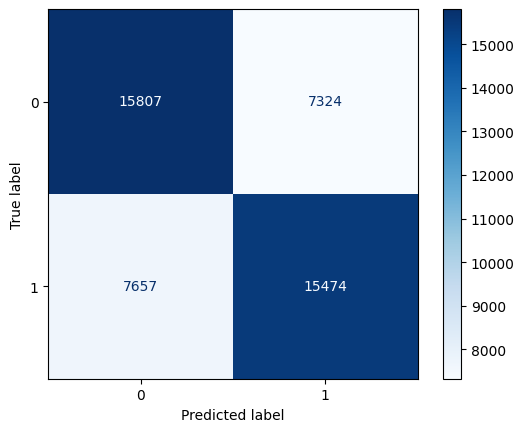

In [57]:
cm = confusion_matrix(Y_smote, y_pred_train1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [58]:
y_pred_test12 = neigh.predict(X_test1_knn) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_test12))
print("Recall: {}".format(recall_score(Y_test,y_pred_test12)))
print("Precisión: {}".format(precision_score(Y_test,y_pred_test12)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred_test12)))

Exactitud: 0.47
Recall: 0.42425451281539844
Precisión: 0.5586342744583059
Puntuación F1: 0.48225824736424444


In [59]:
print(classification_report(Y_test, y_pred_test12))

              precision    recall  f1-score   support

           0       0.39      0.53      0.45      7092
           1       0.56      0.42      0.48     10027

    accuracy                           0.47     17119
   macro avg       0.48      0.48      0.47     17119
weighted avg       0.49      0.47      0.47     17119



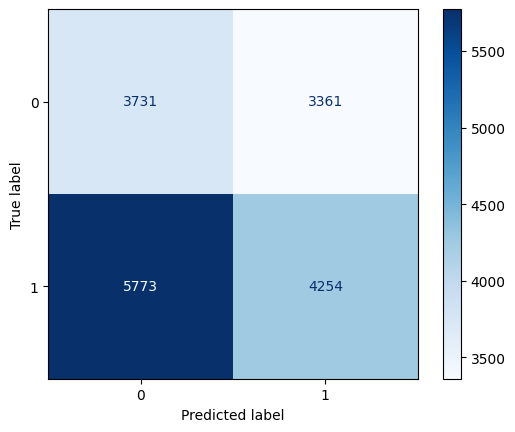

In [60]:
cm = confusion_matrix(Y_test, y_pred_test12)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neigh.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 4.1.2 Estableciendo hiperparametros


In [61]:
param_grid = {
    'n_neighbors': [3, 5, 7],  # Número de vecinos a probar
    "weights": ['uniform', 'distance'] 
}

In [62]:
neigh = KNeighborsClassifier()

mejor_modelo = GridSearchCV(neigh, param_grid, cv=2)

mejor_modelo.fit(X_smote1_knn, Y_smote)
mejor_modelo.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

Metricas con los datos de entrenamiento 

Revisamos metricas con los hiperparametros encontrados

In [63]:
best_knn = mejor_modelo.best_estimator_

y_pred_train = best_knn.predict(X_smote1_knn) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train))
print("Recall: {}".format(recall_score(Y_smote,y_pred_train)))
print("Precisión: {}".format(precision_score(Y_smote,y_pred_train)))
print("Puntuación F1: {}".format(f1_score(Y_smote,y_pred_train)))

Exactitud: 0.71
Recall: 0.6106091392503566
Precisión: 0.7607864260705629
Puntuación F1: 0.6774750575594781


Metricas con los datos de test 

In [64]:

# Obtener los mejores hiperparámetros encontrados
best_params = mejor_modelo.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Usar el mejor modelo encontrado
best_knn = mejor_modelo.best_estimator_

# Evaluar en los datos de prueba
y_pred_test = best_knn.predict(X_test1_knn)

print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_test))
print("Recall:", recall_score(Y_test, y_pred_test))
print("Precisión:", precision_score(Y_test, y_pred_test))
print("Puntuación F1:", f1_score(Y_test, y_pred_test))


Mejores hiperparámetros encontrados: {'n_neighbors': 5, 'weights': 'uniform'}
Exactitud: 0.51
Recall: 0.4390146604168744
Precisión: 0.6078431372549019
Puntuación F1: 0.5098152759279634


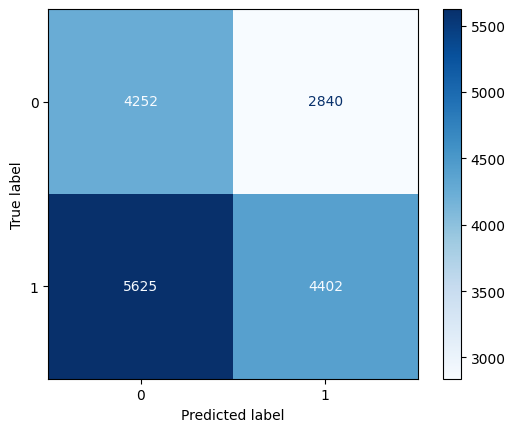

In [65]:
cm = confusion_matrix(Y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mejor_modelo.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

---

## 4.2 Arboles de decision

*Hecho por:*
Juan Sebastan Sanchez - 202121498

Un árbol de decisión es un modelo predictivo que divide el espacio de los predictores agrupando observaciones con valores similares para la variable respuesta.

### 4.2.1 Primer modelo de arbol de decision

Se realiza un primer modelo en donde se especifica que el criterio  como entropia, la profundidad maxima como 4 y los demas hiperparametros son predeterminados

In [66]:
arbol = DecisionTreeClassifier(criterion='entropy', max_depth = 4, random_state = 0)
arbol = arbol.fit(X_smote,Y_smote)

In [67]:
y_pred_train2 = arbol.predict(X_smote)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train2))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train2, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train2, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train2, average='macro')))
print(classification_report(Y_smote, y_pred_train2))

ENTRENAMIENTO
Exactitud: 0.67
Recall: 0.6721499286671566
Precisión: 0.80008104578475
Puntuación F1: 0.6330390585938359
              precision    recall  f1-score   support

           0       1.00      0.35      0.51     23131
           1       0.60      1.00      0.75     23131

    accuracy                           0.67     46262
   macro avg       0.80      0.67      0.63     46262
weighted avg       0.80      0.67      0.63     46262



In [68]:
y_pred_validation22 = arbol.predict(X_test)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_validation22))
print("Recall: {}".format(recall_score(Y_test, y_pred_validation22, average='macro')))
print("Precisión: {}".format(precision_score(Y_test, y_pred_validation22, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test, y_pred_validation22, average='macro')))
print(classification_report(Y_test, y_pred_validation22))

VALIDACIÓN
Exactitud: 0.74
Recall: 0.69233628987408
Precisión: 0.8459285885694121
Puntuación F1: 0.6886087555519294
              precision    recall  f1-score   support

           0       0.99      0.39      0.56      7092
           1       0.70      1.00      0.82     10027

    accuracy                           0.74     17119
   macro avg       0.85      0.69      0.69     17119
weighted avg       0.82      0.74      0.71     17119



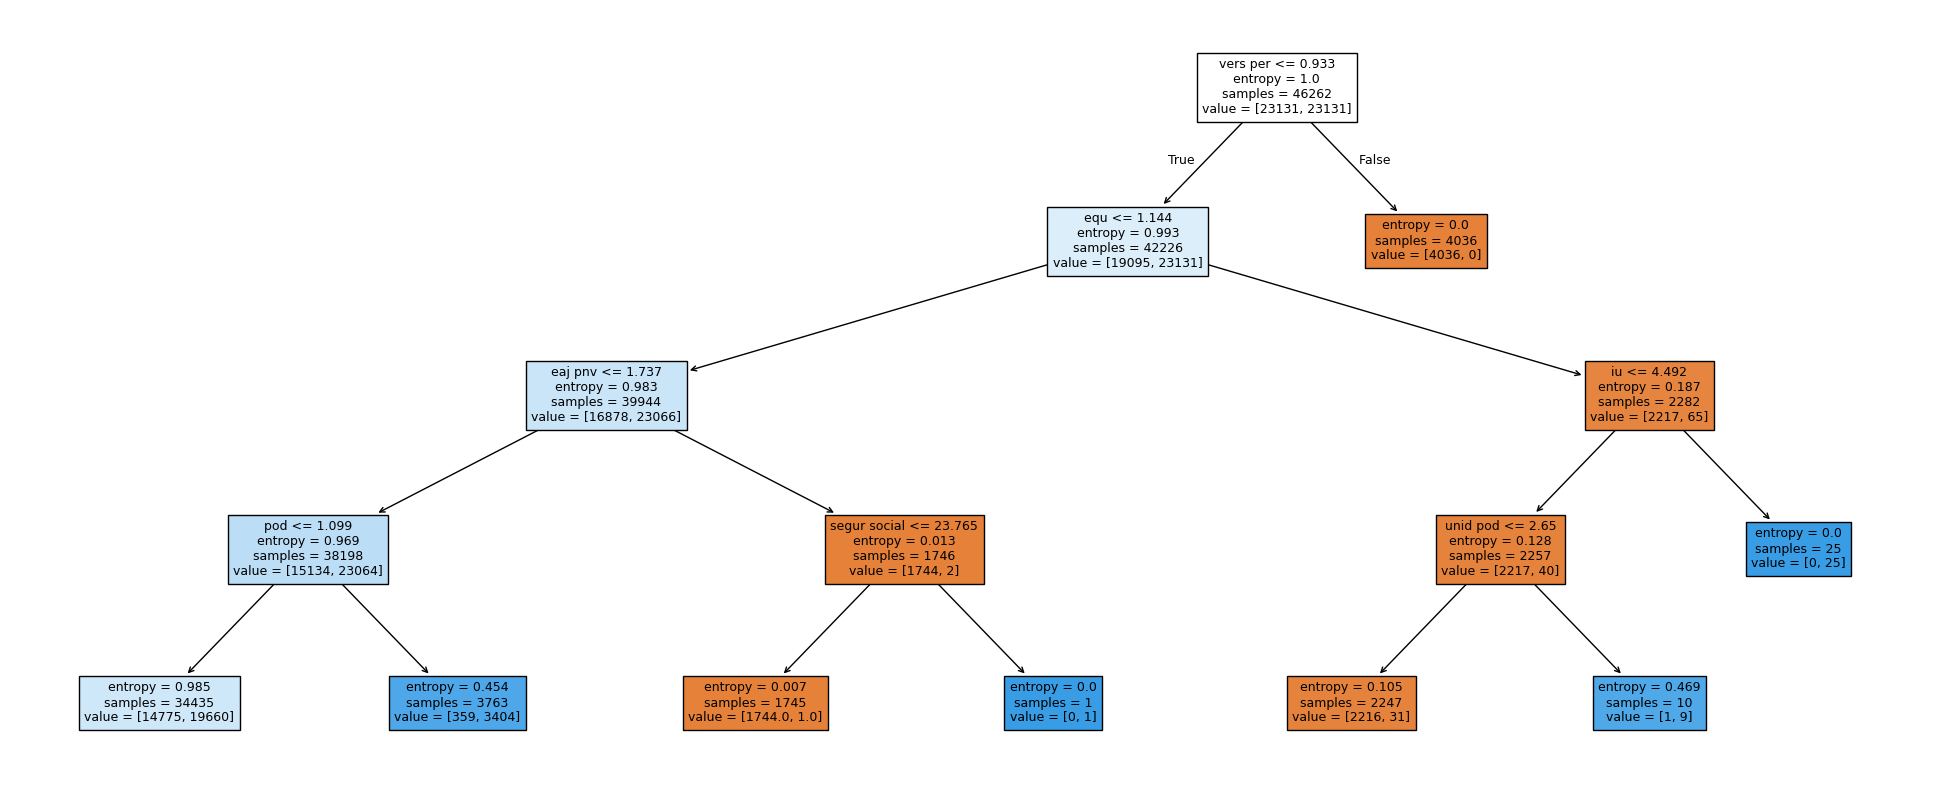

In [69]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol, max_depth=arbol.get_depth(), feature_names=X.columns,filled=True, fontsize=9)

### 4.2.2 Establecimiento de hiperparametros


In [70]:
param_grid = {
    'criterion':['gini', 'entropy'], 
    'max_depth':[4, 8,10,12]
}

In [71]:
arbol = DecisionTreeClassifier(random_state=0)
mejor_modelo = GridSearchCV(arbol, param_grid, cv=2, scoring='recall_macro' )#particiones)
mejor_modelo.fit(X_smote, Y_smote)
mejor_modelo.best_params_

C:\Users\surface\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'gini', 'max_depth': 10}

In [72]:

arbol_final = mejor_modelo.best_estimator_

y_pred_train23 = arbol_final.predict(X_smote)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train23))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train23, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train23, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train23, average='macro')))
print(classification_report(Y_smote, y_pred_train23))

y_pred_validation24 = arbol_final.predict(X_test)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_validation24))
print("Recall: {}".format(recall_score(Y_test, y_pred_validation24, average='macro')))
print("Precisión: {}".format(precision_score(Y_test, y_pred_validation24, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test, y_pred_validation24, average='macro')))
print(classification_report(Y_test, y_pred_validation24))

ENTRENAMIENTO
Exactitud: 0.77
Recall: 0.7676062427045955
Precisión: 0.8355572357530145
Puntuación F1: 0.7552138234628386
              precision    recall  f1-score   support

           0       0.99      0.54      0.70     23131
           1       0.68      0.99      0.81     23131

    accuracy                           0.77     46262
   macro avg       0.84      0.77      0.76     46262
weighted avg       0.84      0.77      0.76     46262

VALIDACIÓN
Exactitud: 0.84
Recall: 0.8056537534781303
Precisión: 0.8827101136610103
Puntuación F1: 0.8183918097841799
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      7092
           1       0.79      0.99      0.88     10027

    accuracy                           0.84     17119
   macro avg       0.88      0.81      0.82     17119
weighted avg       0.87      0.84      0.83     17119



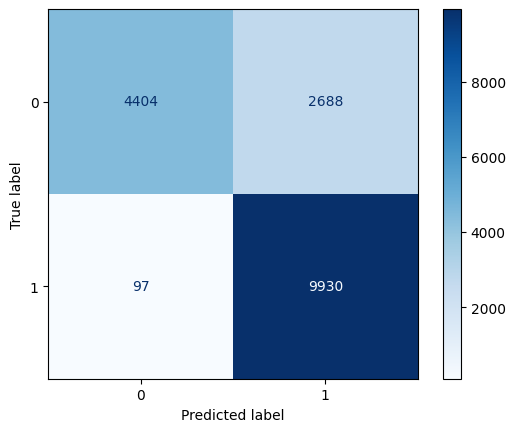

In [73]:
cm = confusion_matrix(Y_test, y_pred_validation24)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol_final.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

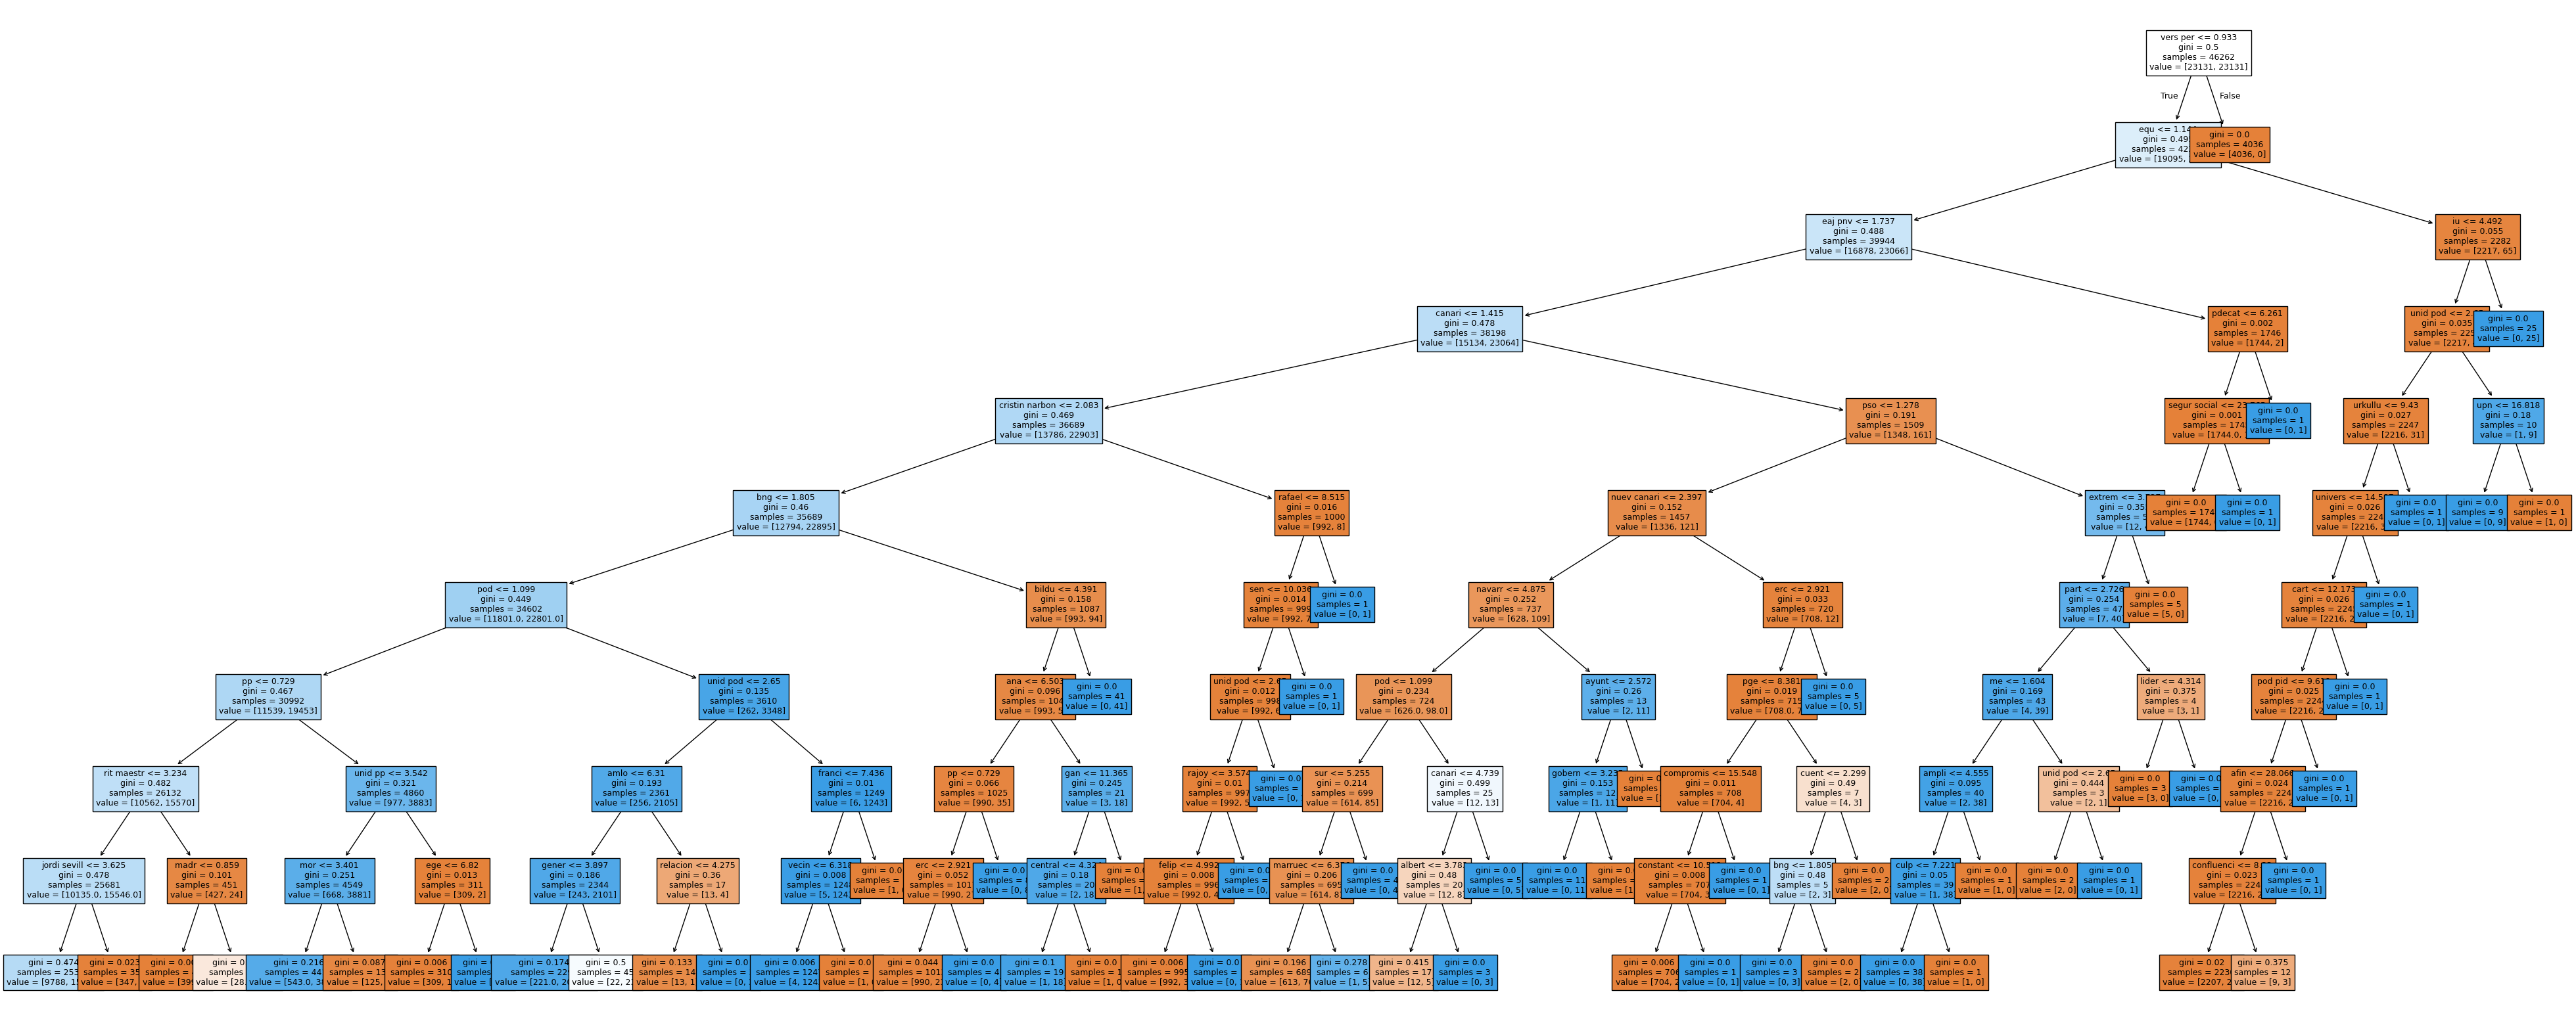

In [74]:
fig = plt.figure(figsize=(50,20))
_ = tree.plot_tree(arbol_final, max_depth=arbol_final.get_depth(), feature_names=X.columns,filled=True, fontsize=9)

---

## 4.3 Gradient Boost - Potenciador del gradiente

*Hecho por:*
Luisa Hernandez - 202114093

Es un algoritmo de ensamble que combina varios árboles de decisión débiles para mejorar su precisión y evitar sobreajuste. Este método funciona entrenando secuencialmente los árboles, donde cada nuevo árbol trata de corregir los errores cometidos por el conjunto de árboles anteriores

### 4.3.1 Primer modelo de Gradient Boost

Se entrena el primer modelo de gradien boost con 100 estimadores y los demas hiperparametros por defecto

In [75]:
clasificador_gradiente = GradientBoostingClassifier(n_estimators=100, random_state=0)
gb_clf = clasificador_gradiente.fit(X_smote, Y_smote)

In [76]:
y_pred_train3 = clasificador_gradiente.predict(X_smote)

print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train3))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train3, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train3, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train3, average='macro')))
print(classification_report(Y_smote, y_pred_train3))

ENTRENAMIENTO
Exactitud: 0.80
Recall: 0.7999005663395444
Precisión: 0.8466565700999107
Puntuación F1: 0.7929179128425639
              precision    recall  f1-score   support

           0       0.97      0.62      0.75     23131
           1       0.72      0.98      0.83     23131

    accuracy                           0.80     46262
   macro avg       0.85      0.80      0.79     46262
weighted avg       0.85      0.80      0.79     46262



In [77]:
y_pred_validation32 = gb_clf.predict(X_test)

print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_validation32))
print("Recall: {}".format(recall_score(Y_test, y_pred_validation32, average='macro')))
print("Precisión: {}".format(precision_score(Y_test, y_pred_validation32, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test, y_pred_validation32, average='macro')))
print(classification_report(Y_test, y_pred_validation32))

VALIDACIÓN
Exactitud: 0.87
Recall: 0.8472672571423203
Precisión: 0.8975355032878748
Puntuación F1: 0.8594144761388641
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      7092
           1       0.83      0.98      0.90     10027

    accuracy                           0.87     17119
   macro avg       0.90      0.85      0.86     17119
weighted avg       0.89      0.87      0.87     17119



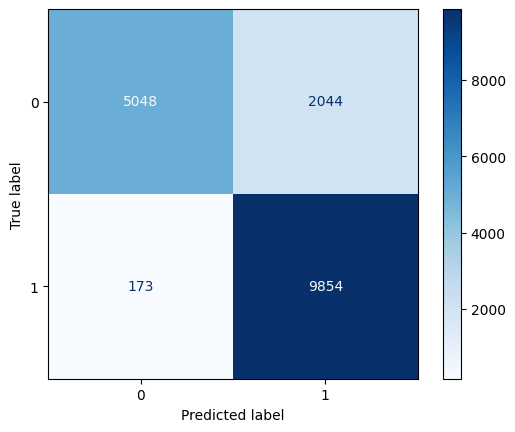

In [78]:
cm = confusion_matrix(Y_test, y_pred_validation32)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### 4.3.2 Busqueda de hiperparametros

In [79]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5]
}

In [80]:
clasificador_gradiente_final = GradientBoostingClassifier(random_state=0)
#particiones = KFold(n_splits=10, shuffle=True, random_state=0)
mejor_modelo = GridSearchCV(clasificador_gradiente_final, param_grid, cv=2)
mejor_modelo.fit(X_smote, Y_smote)
mejor_modelo.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [81]:
clasificador_gradiente_final2 = mejor_modelo.best_estimator_

y_pred_train33 = clasificador_gradiente_final2.predict(X_smote)
print("ENTRENAMIENTO")
print('Exactitud: %.2f' % accuracy_score(Y_smote, y_pred_train33))
print("Recall: {}".format(recall_score(Y_smote, y_pred_train33, average='macro')))
print("Precisión: {}".format(precision_score(Y_smote, y_pred_train33, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_smote, y_pred_train33, average='macro')))
print(classification_report(Y_smote, y_pred_train33))

y_pred_validation34 = clasificador_gradiente_final2.predict(X_test)
print("VALIDACIÓN")
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred_validation34))
print("Recall: {}".format(recall_score(Y_test, y_pred_validation34, average='macro')))
print("Precisión: {}".format(precision_score(Y_test, y_pred_validation34, average='macro')))
print("Puntuación F1: {}".format(f1_score(Y_test, y_pred_validation34, average='macro')))
print(classification_report(Y_test, y_pred_validation34))

ENTRENAMIENTO
Exactitud: 0.82
Recall: 0.8230945484414856
Precisión: 0.8614840613773297
Puntuación F1: 0.8182696186797502
              precision    recall  f1-score   support

           0       0.98      0.66      0.79     23131
           1       0.74      0.99      0.85     23131

    accuracy                           0.82     46262
   macro avg       0.86      0.82      0.82     46262
weighted avg       0.86      0.82      0.82     46262

VALIDACIÓN
Exactitud: 0.89
Recall: 0.8719498527129599
Precisión: 0.9102237425628266
Puntuación F1: 0.8828544454337617
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      7092
           1       0.85      0.98      0.91     10027

    accuracy                           0.89     17119
   macro avg       0.91      0.87      0.88     17119
weighted avg       0.90      0.89      0.89     17119



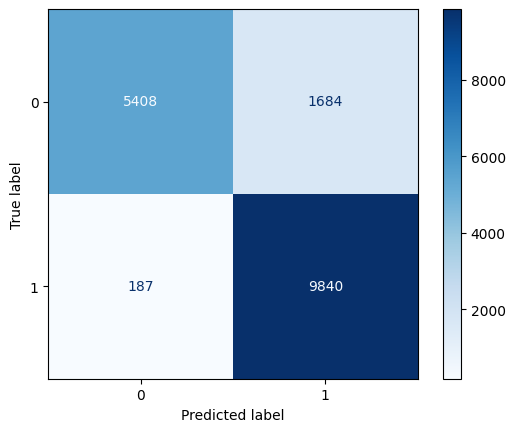

In [82]:
cm = confusion_matrix(Y_test, y_pred_validation34)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasificador_gradiente_final2.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

---
---

# 5. Persistencia del mejor modelo

Vamos a persistir el modelo . Dado que tiene las mejores metricas segun el analisis grupal

In [86]:
import joblib
filename = "modelo_clasificacion.joblib"

In [87]:
dump(clasificador_gradiente_final2, filename)

['modelo_clasificacion.joblib']

In [90]:
# Cargar el modelo desde el archivo .joblib
modelo_cargado = joblib.load(filename)

# Hacer predicciones con el modelo cargado
y_pred_nuevo = modelo_cargado.predict(X_test)

# Evaluación del modelo cargado
print("Exactitud:", accuracy_score(Y_test, y_pred_nuevo))
print("Recall:", recall_score(Y_test, y_pred_nuevo))
print("Precisión:", precision_score(Y_test, y_pred_nuevo))
print("Puntuación F1:", f1_score(Y_test, y_pred_nuevo))


Exactitud: 0.8907062328407033
Recall: 0.981350354044081
Precisión: 0.8538701839639015
Puntuación F1: 0.9131826829381468
